In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy import stats
from sklearn.metrics import mean_squared_error

In [186]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

In [189]:
df.head(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t","ln_RV_w,t","ln_RV_m,t"
time,,,,,,,,,,,,
2016-03-09,11.197,11.197,11.197,10.660,41.139523,0.014515,NaN,NaN,NaN,-4.232581,NaN,NaN
2016-03-10,11.072,11.750,11.850,11.072,1.030000,0.003658,0.049388,NaN,NaN,-5.610725,NaN,NaN


In [190]:
df.tail(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t","ln_RV_w,t","ln_RV_m,t"
time,,,,,,,,,,,,
2023-10-07,1645.5,1634.5,1647.9,1630.5,953.564307,0.000047,-0.006806,0.000688,0.000363,-9.962319,-7.282344,-7.921201
2023-10-08,1634.5,1626.5,1641.2,1625.9,646.669448,0.000027,-0.004894,0.000342,0.000358,-10.506913,-7.981488,-7.935023


In [178]:
# Train-Test Split (80% train, 10% validation, 10% test)
# (daily_return would be the input for GARCH models)

train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))

r_train = df.daily_return[:train_size]
r_val = df.daily_return[train_size:train_size+valid_size]
RV_val = df['RV_d,t'][train_size:train_size+valid_size]
r_test = df.daily_return[train_size+valid_size:]

In [179]:
r_train.dropna(inplace=True)

In [162]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

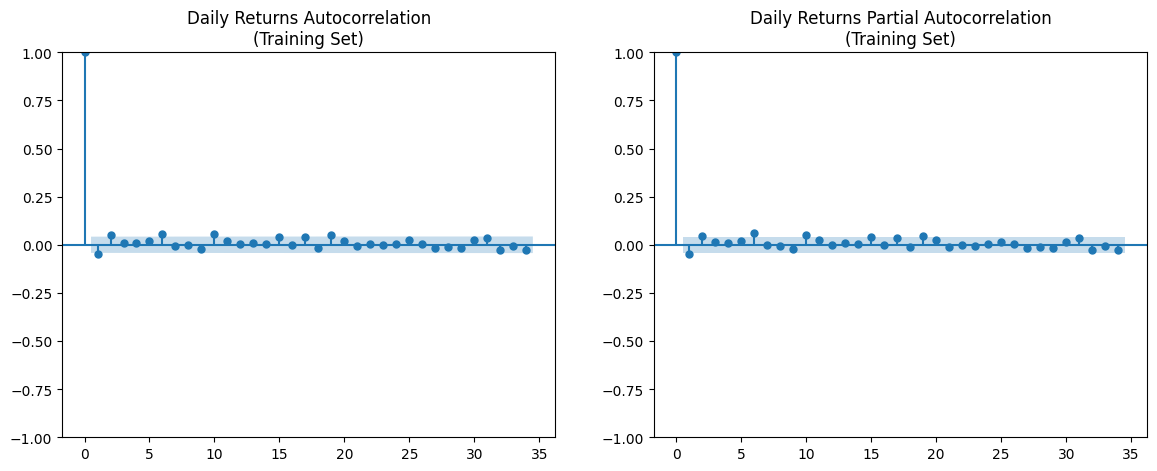

In [180]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

In [288]:
gm_1 = arch_model(r_train, p=1, q=1)
gm1_fit = gm_1.fit(disp='off')

c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [289]:
# Extract GARCH(1,1) parameters
omega = gm1_fit.params['omega']
alpha = gm1_fit.params['alpha[1]']
beta = gm1_fit.params['beta[1]']
print(f"Estimated Parameters: omega={omega:.6f}, alpha={alpha:.6f}, beta={beta:.6f}")

Estimated Parameters: omega=0.000318, alpha=0.100002, beta=0.799998


In [290]:
# Get the last conditional variance from training
last_train_variance = df['RV_d,t'][:train_size].iloc[-1]
last_daily_return = r_train[-1]

# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute volatility iteratively using GARCH equation
for r in r_val:
    new_variance = omega + alpha * (last_daily_return ** 2) + beta * last_train_variance
    predicted_volatility.append(np.sqrt(new_variance))  # Convert variance to standard deviation
    # Update for next step
    last_train_variance = new_variance  
    last_daily_return = r


C:\Users\65835\AppData\Local\Temp\ipykernel_28600\2534954084.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_daily_return = r_train[-1]


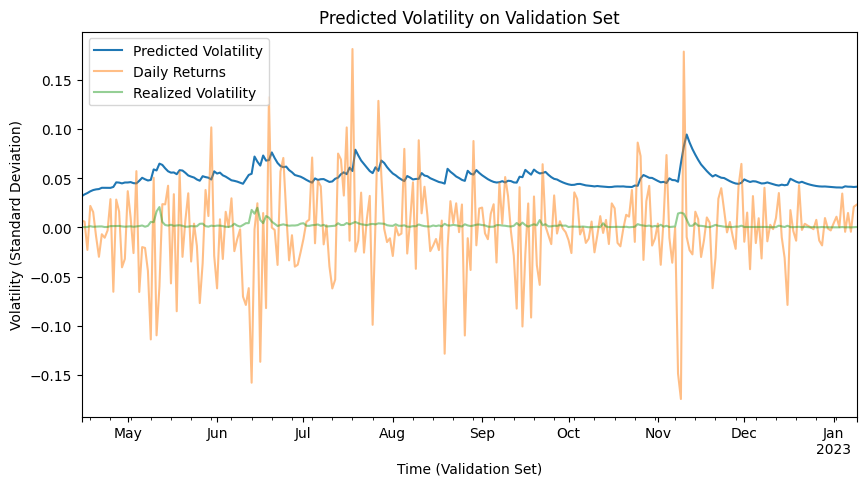

In [291]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_val.index)

# Plot the predicted volatility
plt.figure(figsize=(10, 5))
df_pred['Predicted Volatility'].plot(label='Predicted Volatility')
r_val.plot(label='Daily Returns', alpha=0.5)
RV_val.plot(label='Realized Volatility', alpha=0.5)
plt.xlabel("Time (Validation Set)")
plt.ylabel("Volatility (Standard Deviation)")
plt.title("Predicted Volatility on Validation Set")
plt.legend()
plt.show()